In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from identification import *

plt.style.use('default')

# Validação dos modelos

In [4]:
def number_of_zeros(x):
    for i in range(x.size):
        if x[i] != 0:
            return i
    return 0

In [2]:
df_data_n11 = pd.read_csv('../data/entrada_saida_nsenos_n11_111v.csv', header=None)

df_theta_hat_2o = pd.read_csv('../data/theta_hat_2o_emax_111.csv', header=None)
df_theta_hat_ed = pd.read_csv('../data/theta_hat_ed_emax_111.csv', header=None)

In [3]:
data_n11  = np.array(df_data_n11    , ndmin=2)
u_ar_n11  = np.array(df_data_n11[0] , ndmin=2).T
y_ar_n11  = np.array(df_data_n11[1] , ndmin=2).T

theta_hat_2o = np.array(df_theta_hat_2o, ndmin=2)
theta_hat_ed = np.array(df_theta_hat_ed, ndmin=2)

In [5]:
nz = number_of_zeros(y_ar_n11)
y_ar_n11 = y_ar_n11[nz-1:]
u_ar_n11 = u_ar_n11[nz-1:]

In [6]:
print(y_ar_n11[:2].T)

[[  0.         151.36558196]]


In [7]:
y_hat_2o_n11 =    estimate_output(y=y_ar_n11, u=u_ar_n11, theta=theta_hat_2o, ord=2)
y_hat_ed_n11 = estimate_output_ed(y=y_ar_n11 ,u=u_ar_n11 ,theta=theta_hat_ed)

In [8]:
T1 = 0
T2 = -1

V_2o = cost_func(y_ar_n11[T1:T2], y_hat_2o_n11[T1:T2])
V_ed = cost_func(y_ar_n11[T1:T2], y_hat_ed_n11[T1:T2])


print('Resultados validação n=11:')

print(f'ARX 2ª ordem V = {V_2o}')
print(f'discretizado V = {V_ed}')

Resultados validação n=11:
ARX 2ª ordem V = 4377.360720434349
discretizado V = 1797.1948662323043


Discretização

In [14]:
delta_tempo = 1e-5

y_hat_2o_d    = np.zeros(y_hat_2o_n11.shape)
nz = number_of_zeros(y_hat_2o_n11)
periodos = 1/y_hat_2o_n11[nz:]
periodos_d = delta_tempo * np.floor(periodos / delta_tempo)
y_hat_2o_d[nz:] = 1/periodos_d

y_hat_ed_d = np.zeros(y_hat_ed_n11.shape)
nz = number_of_zeros(y_hat_ed_n11)
periodos_ed = 1/y_hat_ed_n11[nz:]
periodos_ed_d = delta_tempo * np.floor(periodos_ed / delta_tempo)
y_hat_ed_d[nz:] = 1/periodos_ed_d

In [15]:
T1 = 0
T2 = -1


V_2o_d = cost_func(y_ar_n11[T1:T2], y_hat_2o_d[T1:T2])
V_ed_d = cost_func(y_ar_n11[T1:T2], y_hat_ed_d[T1:T2])


print('Resultados validação n=11:')
print(f'ARX 2ª ordem V = {np.round(V_2o,2)}, V_d = {np.round(V_2o_d,2)}')
print(f'discretizado V = {np.round(V_ed,2)}, V_d = {np.round(V_ed_d,2)}')

Resultados validação n=11:
ARX 2ª ordem V = 4377.36, V_d = 4436.91
discretizado V = 1797.19, V_d = 1793.96


# Análise dos resíduos

In [16]:
# e_t = y_t - y_hat_t
e_2o_n11_d = y_ar_n11 - y_hat_2o_d
e_ed_n11_d = y_ar_n11 - y_hat_ed_d

In [17]:
df = pd.DataFrame(e_2o_n11_d)
df.to_csv('../data/e_2o_n11_d.csv',header=False,index=False)
df = pd.DataFrame(e_ed_n11_d)
df.to_csv('../data/e_ed_n11_d.csv',header=False,index=False)

In [18]:
T1 = 0

S1_2o = np.max(np.abs(e_2o_n11_d[T1:]))
S1_ed = np.max(np.abs(e_ed_n11_d[T1:]))

print(f'S1_2o = {S1_2o}')
print(f'S1_ed = {S1_ed}')

S1_2o = 769.1728908602868
S1_ed = 819.1109375225512


R_{eu}^N(tau) = de t=1 a N e_res(t) * u(t - tau) /u.size

In [19]:
# função de covariança como mostrada no livro
def prev_cov(e,u):
    Tau = np.arange(u.size)
    R = np.zeros(u.shape)
    for tau in Tau:
        N = np.arange(tau,u.size)
        for t in N:
            R[tau] += (e[t] * u[t-tau])
    return R / u.size

In [21]:
T1 = 0

R_eu_2o = prev_cov(e_2o_n11_d[T1:],u_ar_n11[T1:])
R_eu_ed = prev_cov(e_ed_n11_d[T1:],u_ar_n11[T1:])

R_e_2o = prev_cov(e_2o_n11_d[T1:],e_2o_n11_d[T1:])
R_e_ed = prev_cov(e_ed_n11_d[T1:],e_ed_n11_d[T1:])
                        
R_u_2o = prev_cov(u_ar_n11[T1:],u_ar_n11[T1:])
R_u_ed = prev_cov(u_ar_n11[T1:],u_ar_n11[T1:])

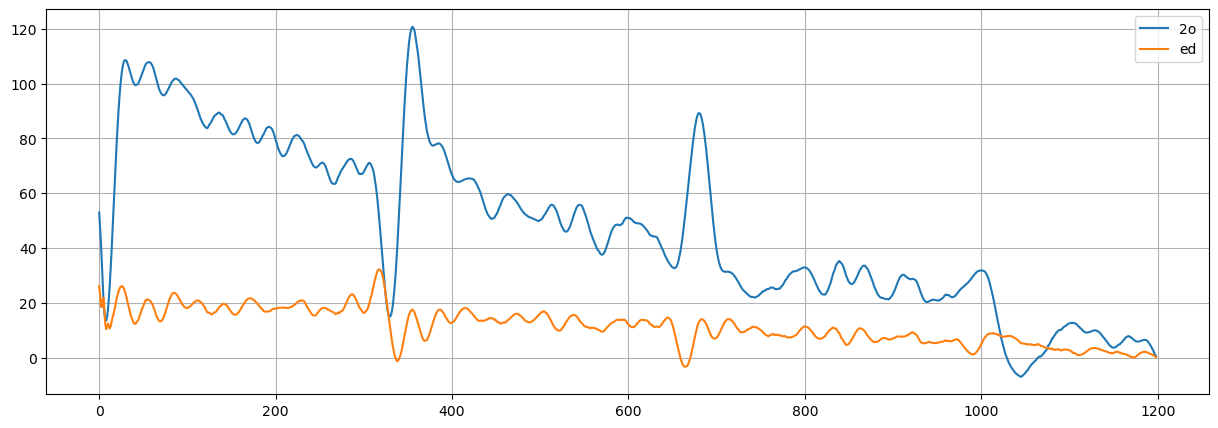

In [23]:
plt.figure(figsize=[15,5])
plt.grid(True)

plt.plot(R_eu_2o,label='2o')
plt.plot(R_eu_ed,label='ed')
plt.legend()

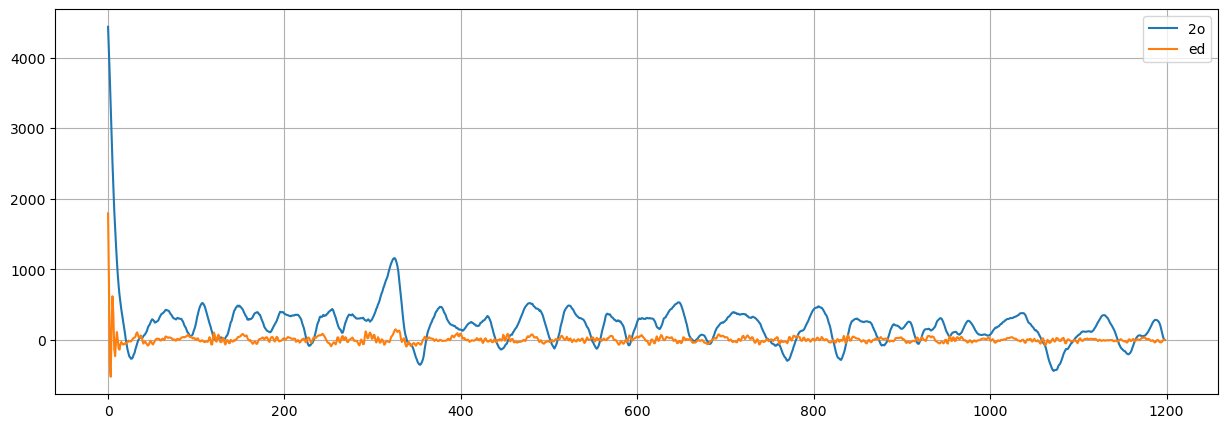

In [24]:
plt.figure(figsize=[15,5])
plt.grid(True)

plt.plot(R_e_2o,label='2o')
plt.plot(R_e_ed,label='ed')
plt.legend()

## De onde vem M?

In [25]:
zeta_N_M_2o = R_e_2o.size/np.power(R_e_2o[0],2) * np.sum(np.power(R_e_2o,2))
zeta_N_M_ed = R_e_ed.size/np.power(R_e_ed[0],2) * np.sum(np.power(R_e_ed,2))

In [26]:
print(zeta_N_M_2o)
print(zeta_N_M_ed)

[11637.88744385]
[2366.03804482]


In [27]:
P1_2o = np.sum(R_e_2o*R_u_2o)
P1_ed = np.sum(R_e_ed*R_u_ed)

In [28]:
print(P1_2o)
print(P1_ed)

5223424.010901481
185537.99807530246


In [29]:
# alfa = 0.1
N_alfa = 1.65

In [30]:
print(f'sqrt(P1/N) _hall_arx = {np.sqrt(P1_2o/e_2o_n11_d.size)}')
print(f'sqrt(P1/N) _hall_ed  = {np.sqrt(P1_ed/e_ed_n11_d.size)}')

sqrt(P1/N) _hall_arx = 66.00366463719408
sqrt(P1/N) _hall_ed  = 12.439612200111371


In [31]:
lim_2o = np.sqrt(P1_2o/e_2o_n11_d.size)*(N_alfa)
lim_ed  = np.sqrt(P1_ed/e_ed_n11_d.size)*(N_alfa)

print(f'sqrt(P1/N)*N_alfa _2o  = {lim_2o}')
print(f'sqrt(P1/N)*N_alfa _ed  = {lim_ed}')

sqrt(P1/N)*N_alfa _2o  = 108.90604665137022
sqrt(P1/N)*N_alfa _ed  = 20.525360130183763


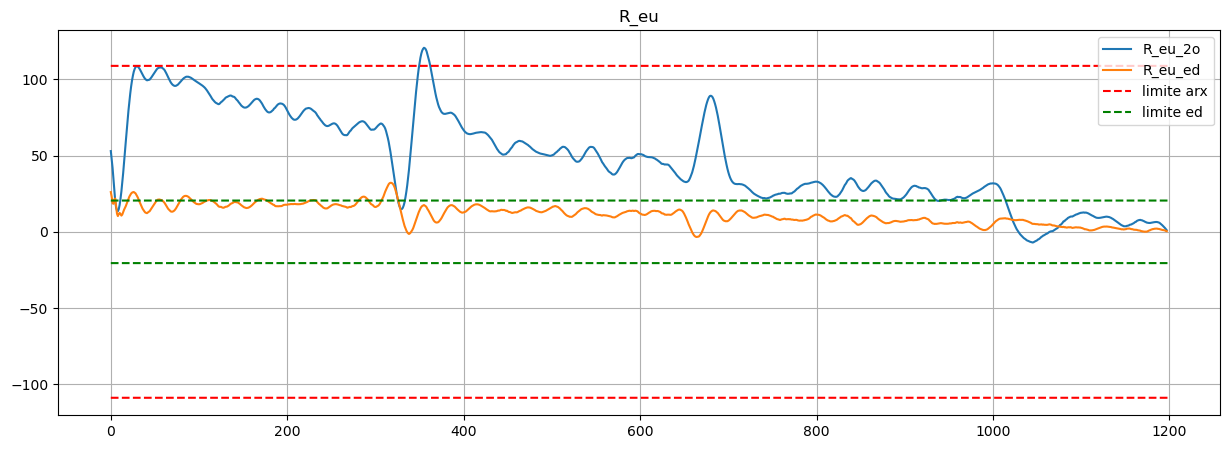

In [32]:
T1 = 0
T2 = -1
T3 = -1
T4 = -T3

lim_sup_2o = np.ones(R_eu_2o.shape)*lim_2o
lim_sup_ed = np.ones(R_eu_ed.shape)*lim_ed
plt.figure(1,figsize=[15,5])
plt.grid(True)
#plt.ylim([T3,T4])

plt.title('R_eu')
plt.plot(R_eu_2o[T1:T2],label='R_eu_2o')
plt.plot(R_eu_ed[T1:T2],label='R_eu_ed')
plt.plot( lim_sup_2o,'--',color='red',label='limite arx')
plt.plot(-lim_sup_2o,'--',color='red')
plt.plot( lim_sup_ed, '--',color='green',label='limite ed')
plt.plot(-lim_sup_ed, '--',color='green')
plt.legend()

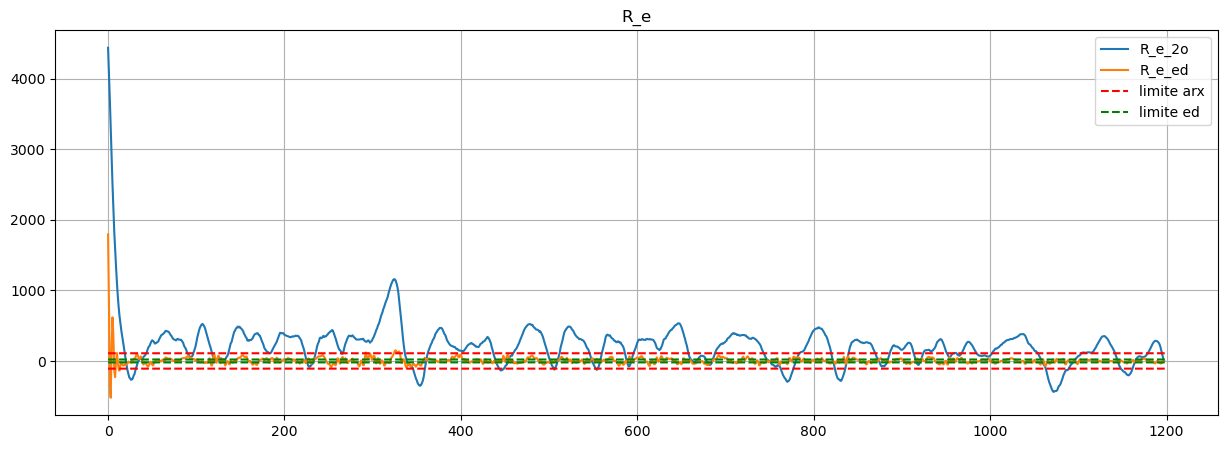

In [33]:
T1 = 0
T2 = -1
T3 = -15
T4 = 70

lim_sup_2o = np.ones(R_e_2o.shape)*lim_2o
lim_sup_ed = np.ones(R_e_ed.shape)*lim_ed
plt.figure(figsize=[15,5])
plt.grid(True)
#plt.ylim([T3,T4])

plt.title('R_e')
plt.plot(R_e_2o[T1:T2],label='R_e_2o')
plt.plot(R_e_ed[T1:T2],label='R_e_ed')
plt.plot( lim_sup_2o,'--',color='red',label='limite arx')
plt.plot(-lim_sup_2o,'--',color='red')
plt.plot( lim_sup_ed, '--',color='green',label='limite ed')
plt.plot(-lim_sup_ed, '--',color='green')
plt.legend()